# Reproducing experiment 6.2 from Tramdag paper

In [1]:
import os
# from tramdag.utils.configuration import *

from tramdag import TramDagConfig
from sklearn.model_selection import train_test_split

In [2]:
experiment_name = "plot_ordinal_trafo_fkt"      ## <--- set experiment name
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"  ## <--- set log directory
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")
cfg=TramDagConfig()
cfg.setup_configuration(experiment_name,EXPERIMENT_DIR)

Configuration already exists: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/configuration.json


Setting seed: 42
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x1      100000 non-null  float64
 1   x2      100000 non-null  float64
 2   x3      100000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.3 MB
Train size: 80000, Validation size: 10000, Test size: 10000


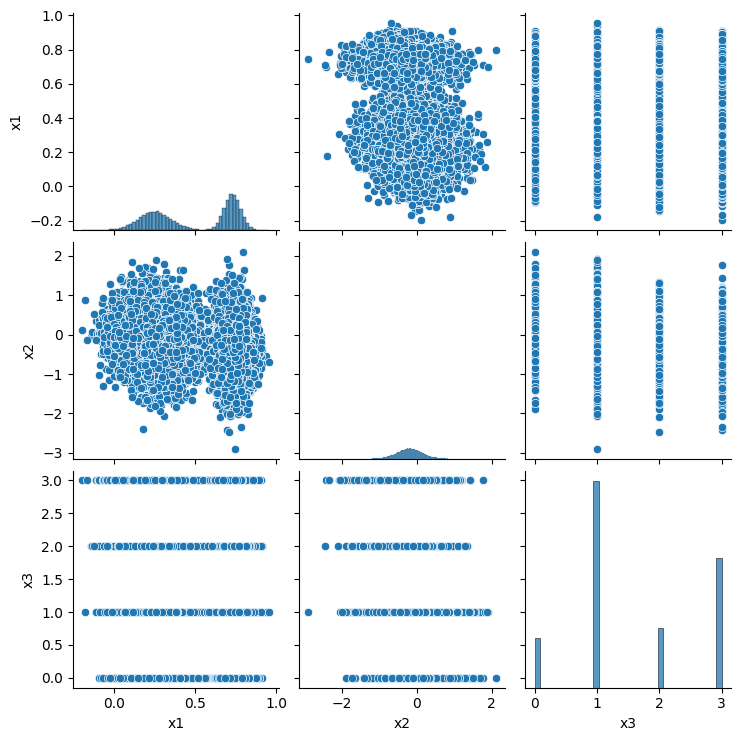

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

def dgp(n_obs, doX=[None, None, None], f=lambda x: x, seed=None):
    """
    Data-generating process matching the provided R implementation.
    
    Parameters
    ----------
    n_obs : int
        Number of observations to generate.
    doX : list of length 3
        If doX[i] is not None, fixes X_{i+1} to that constant for all draws.
    f : callable
        A function of X2 used in generating X3 (defaults to identity).
    seed : int or None
        If provided, sets the NumPy random seed.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['x1', 'x2', 'x3'], where x3 is an ordered
        categorical with levels 1 < 2 < 3 < 4.
    """
    if seed is not None:
        np.random.seed(seed)
        print(f"Setting seed: {seed}")

    # --- 1. Sample X1 from a 2-component GMM ---
    if doX[0] is None:
        X1_A = np.random.normal(loc=0.25, scale=0.10, size=n_obs)
        X1_B = np.random.normal(loc=0.73, scale=0.05, size=n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, X1_A, X1_B)
    else:
        x1 = np.full(n_obs, doX[0], dtype=float)

    # --- 2. Sample X2 via shifted-logit inversion (as in R) ---
    if doX[1] is None:
        # draw U2 ~ Uniform(0,1) and map through quantile of logistic
        u2 = np.random.uniform(size=n_obs)
        z2 = np.log(u2 / (1 - u2))  # qlogis
        # replicate: X2 = (z2 - 2 * x1) / 5
        x2 = (z2 - 2 * x1) / 5.0
    else:
        x2 = np.full(n_obs, doX[1], dtype=float)

    # --- 3. Sample X3 as an ordinal via logistic thresholds ---
    if doX[2] is None:
        # latent U3 ~ Logistic(0,1)
        u3 = np.random.logistic(loc=0.0, scale=1.0, size=n_obs)
        # thresholds theta_k = (-2, 0.42, 1.02)
        theta = np.array([-2.0, 0.42, 1.02])
        # compute h[i,k] = theta_k + 0.2 * x1[i] + f(x2[i])
        h = theta + 0.2 * x1.reshape(-1, 1) + f(x2).reshape(-1, 1)
        # assign x3 starting at 0
        x3 = np.zeros(n_obs, dtype=int)
        x3[u3 > h[:, 0]] = 1
        x3[u3 > h[:, 1]] = 2
        x3[u3 > h[:, 2]] = 3
        # convert to ordered categorical
        x3 = pd.Categorical(x3, categories=[0, 1, 2, 3], ordered=True)
    else:
        x3 = pd.Categorical(
            np.full(n_obs, doX[2], dtype=int),
            categories=[0, 1, 2, 3],
            ordered=True
        )
        
    # x3 = x3.astype(float) / 4.0
    x3 = x3.astype(int) 
    return pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})

df = dgp(n_obs=100_000, seed=42)
df.info()
sns.pairplot(df)

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


In [4]:
data_type= {'x1':'continous','x2':'continous','x3':'ordinal_Xn_Yo'} 
cfg.set_data_type(data_type)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
x2                   | continous       | continuous [c]                 | continuous [c]                
x3                   | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
---------------------------------------------------------------------------------------------------------
Configuration updated successfully at /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/configuration.json.


/home/bule/TramDag/tramdag/utils/configuration.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


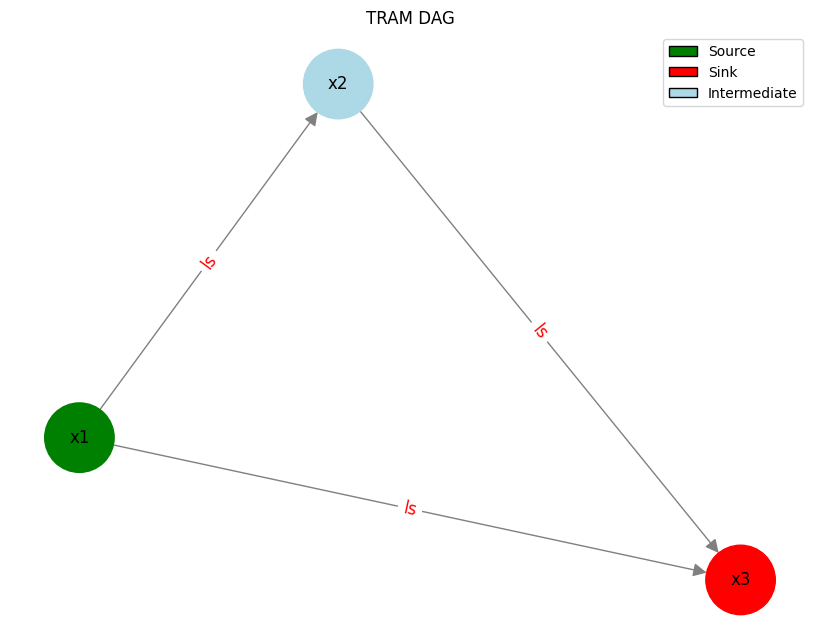

In [5]:
cfg.set_meta_adj_matrix()



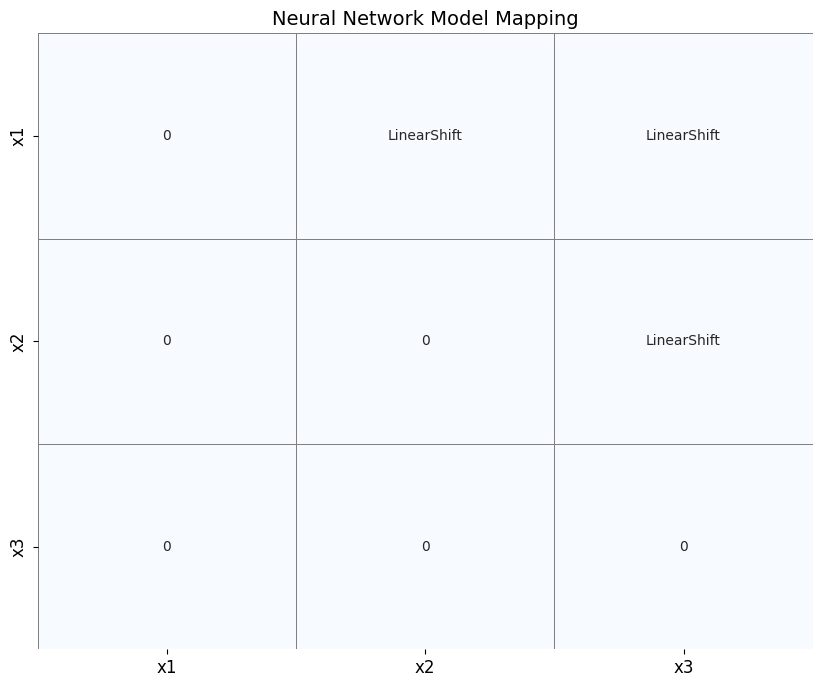

In [6]:
cfg.set_tramdag_nn_models()

# Model training & sampling

In [7]:
from tramdag import TramDagModel

cfg.compute_levels(train_df)
device='cpu'

In [8]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=False,device=device,initial_data = train_df) 


In [9]:
td_model.fit(train_df, val_df,
            #  train_list=['target'],
             learning_rate=1e-2,
             epochs=150,batch_size=1000,
             verbose=False,debug=False,
             device=device,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,
             train_mode = "sequential")#,

In [10]:
# td_model.plot_loss_history()

```
  Continuous Outcome Logistic Regression 

Call:
Colr(formula = x2 ~ x1, data = data_6_2)

Coefficients:
      x1 
1.973891 

Log-Likelihood:
 -31293.99 (df = 8)
```
---------------------------------------------------
```
# > polr(x3_factor ~ x1 + x2, data = data_6_2)
# Call:
# polr(formula = x3_factor ~ x1 + x2, data = data_6_2)

# Coefficients:
#         x1         x2 
# -0.1815344 -1.0012274 
```

In [11]:
# td_model.plot_linear_shift_history(ref_lines={'x2':[1.973827],'x3':[-0.1815344, -1.0012274 ]}) 

```
# > polr(x3_factor ~ x1 + x2, data = data_6_2)
# Call:
# polr(formula = x3_factor ~ x1 + x2, data = data_6_2)

# Coefficients:
#         x1         x2 
# -0.1815344 -1.0012274 

# Intercepts:
#       0|1       1|2       2|3 
# -1.998953  0.426397  1.032376 

# Residual Deviance: 194022.51 
# AIC: 194032.51 
```

In [12]:
# [-2.054361   0.3095475  0.897935 ]

# td_model.plot_simple_intercepts_history(ref_lines={'x3':[-1.998953,  0.426397,  1.032376]})

In [13]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# === Load your predictions ===
path = "/home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x3_ordinal_predictions_20251108_210105.csv"
df = pd.read_csv(path)

# === Define true and predicted labels ===
y_true = df["x3"].astype(int)
y_pred = df["pred_class"].astype(int)

# === Compute metrics ===
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, digits=3)

print(f"Model accuracy: {acc:.3f}")
print("\nConfusion matrix:\n", cm)
print("\nClassification report:\n", report)

        



Model accuracy: 0.453

Confusion matrix:
 [[  0  28   0   1]
 [  0 121   0   7]
 [  0  35   0   3]
 [  0  90   0  15]]

Classification report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000        29
           1      0.442     0.945     0.602       128
           2      0.000     0.000     0.000        38
           3      0.577     0.143     0.229       105

    accuracy                          0.453       300
   macro avg      0.255     0.272     0.208       300
weighted avg      0.390     0.453     0.337       300



/home/bule/anaconda3/envs/tramdag/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bule/anaconda3/envs/tramdag/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bule/anaconda3/envs/tramdag/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

[WARNING] len(df)>1, set: plot_n_rows accordingly
[WARNING] Node x3 is categorical, not implemented yet


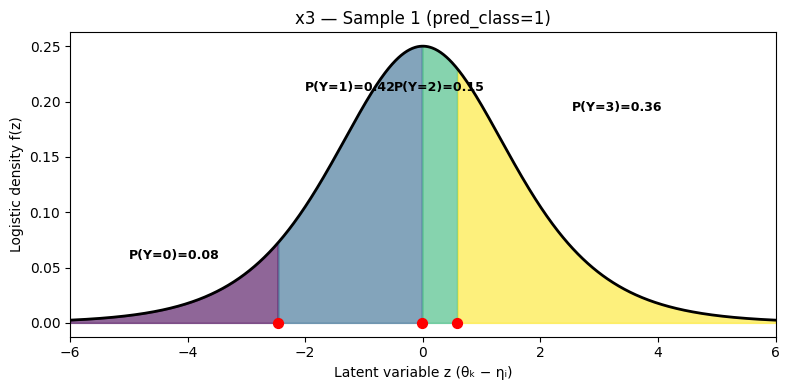

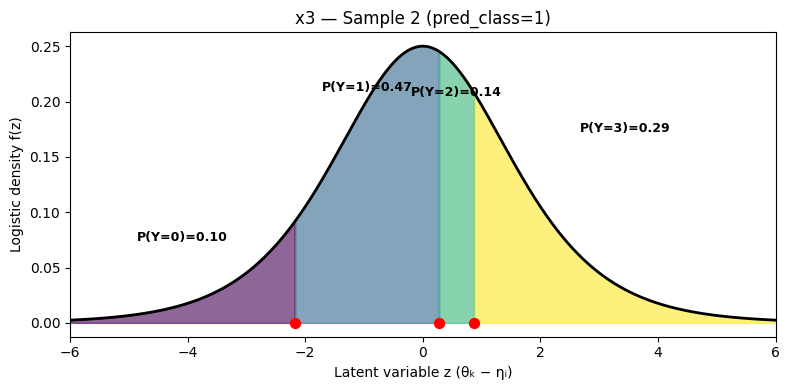

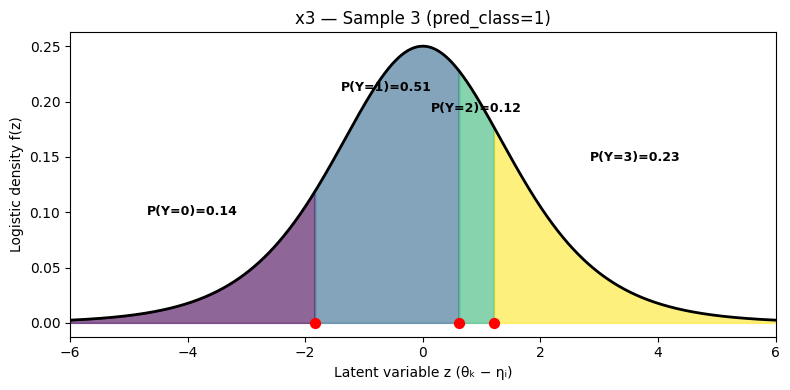

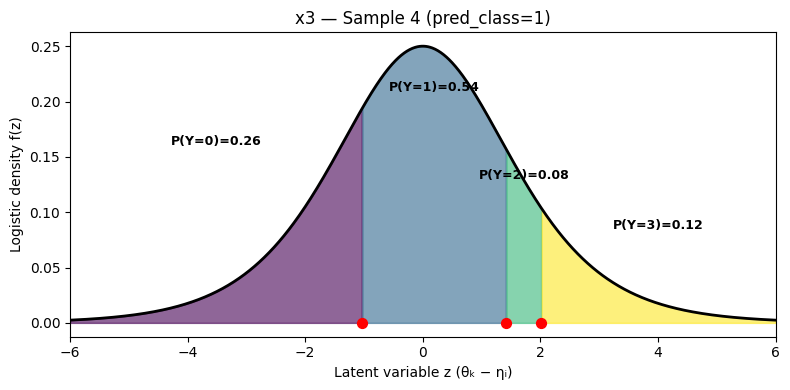

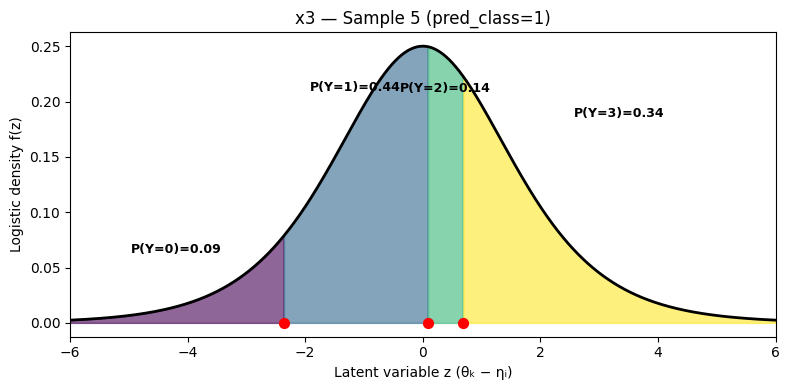

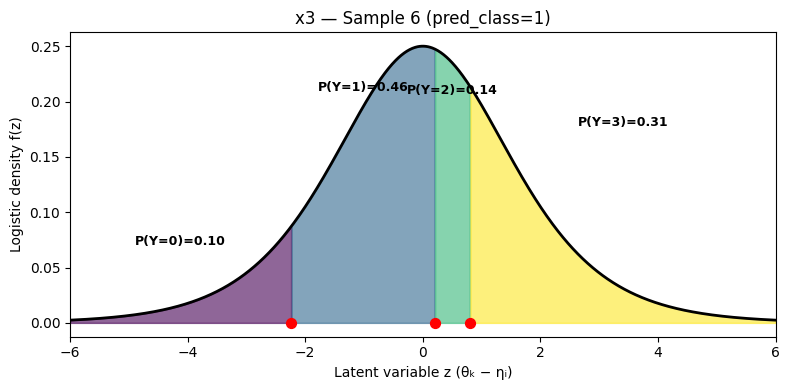

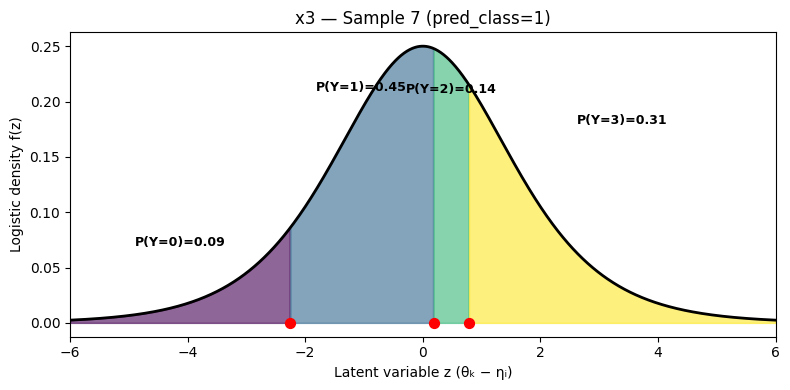

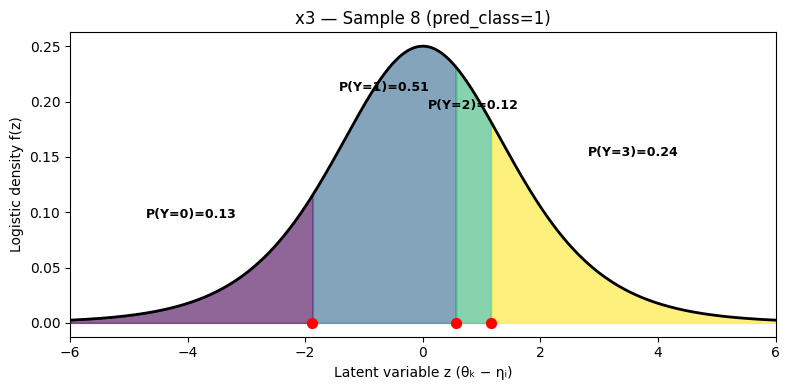

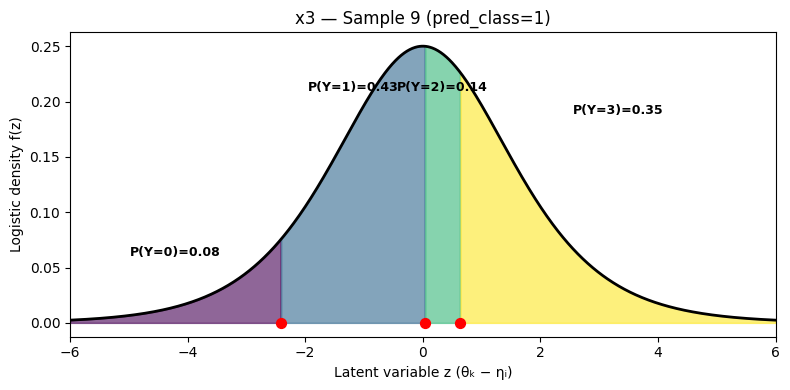

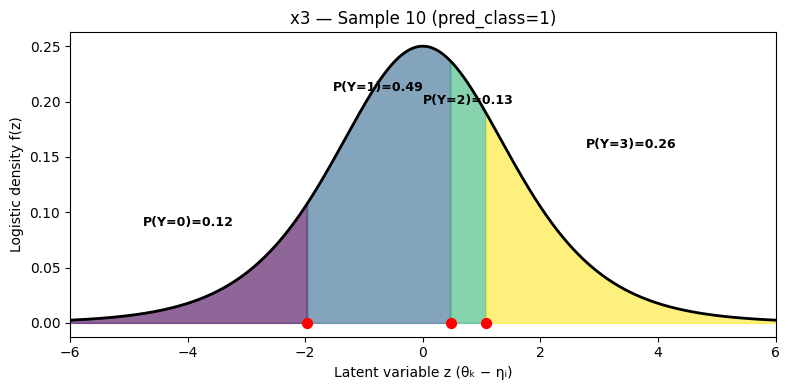

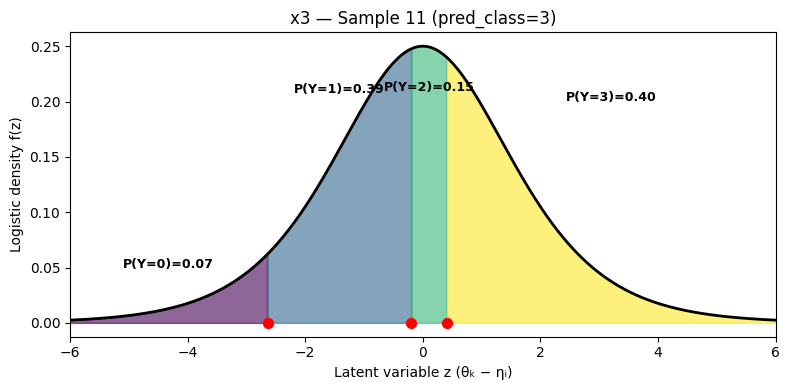

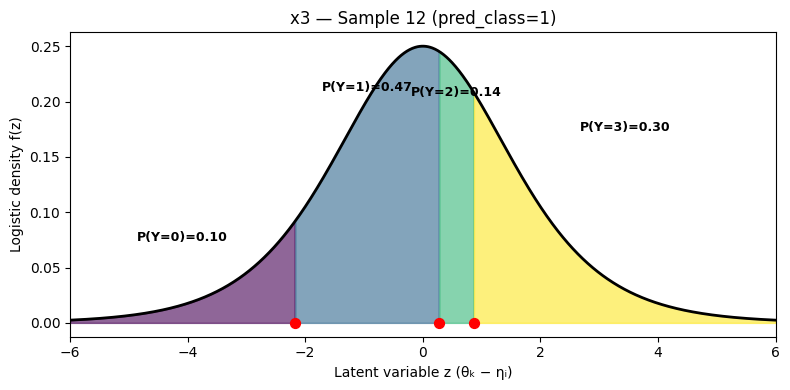

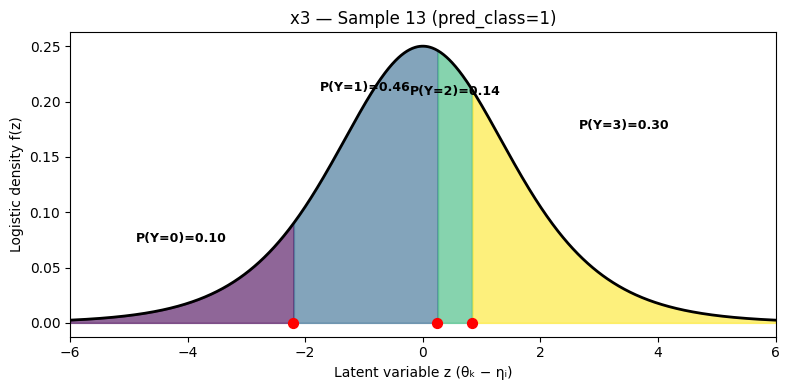

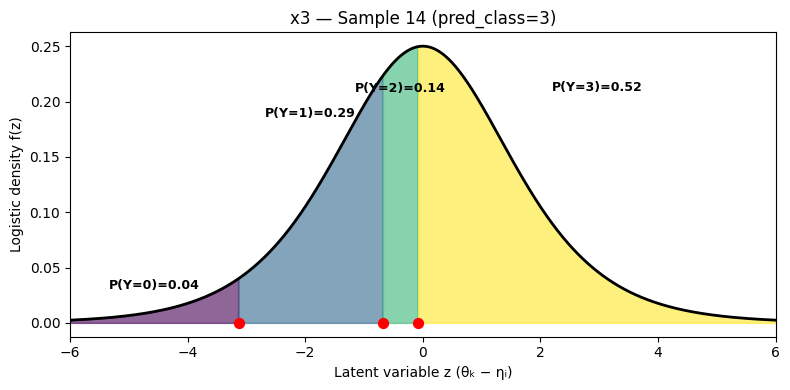

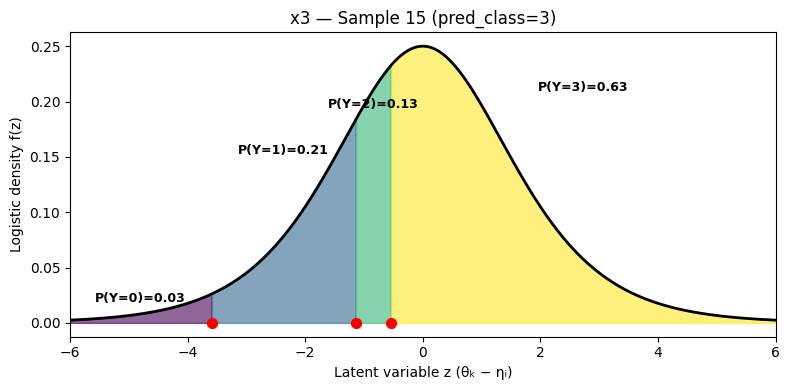

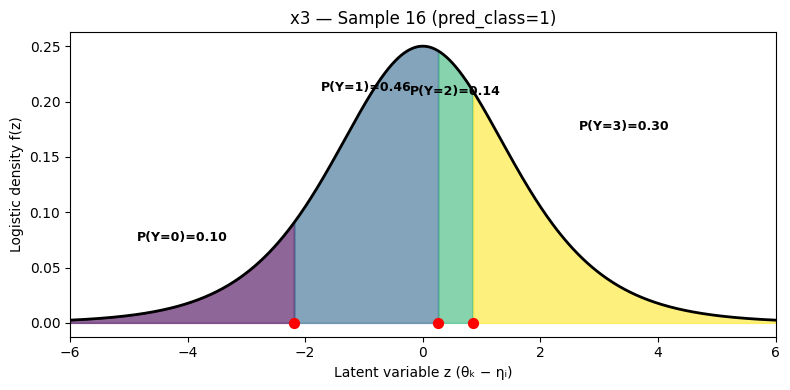

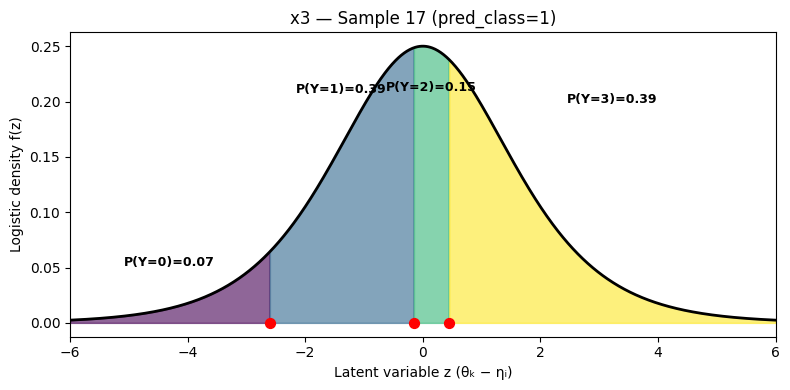

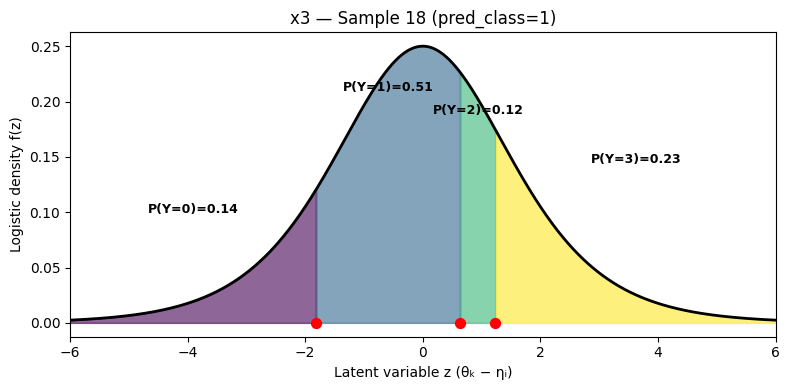

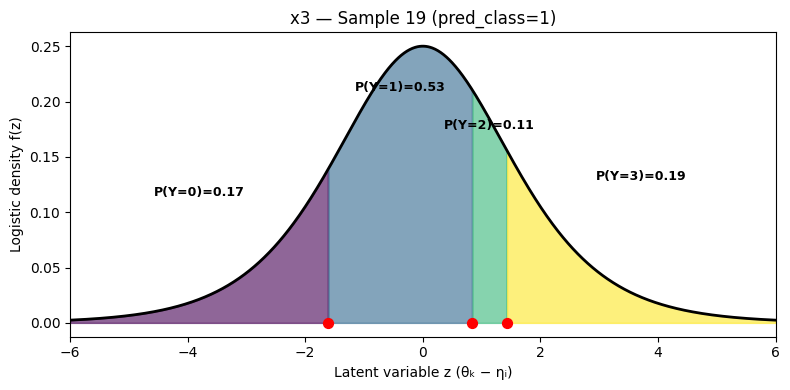

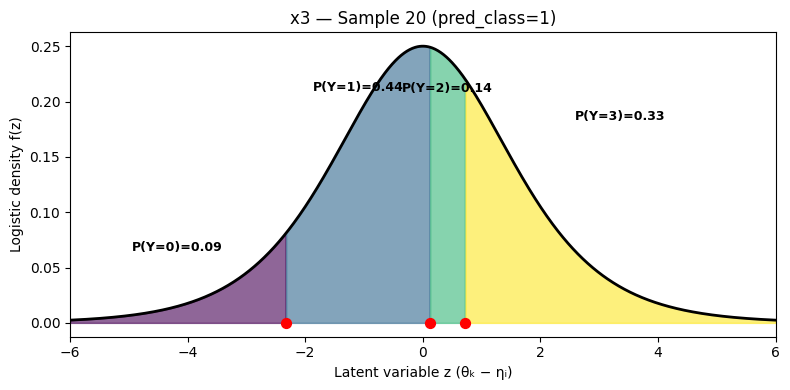


Saved predictions and argmaxes to: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x3_ordinal_predictions_20251108_213335.csv


In [14]:
td_model.plot_hdag(train_df,variables=['x3'],plot_n_rows=20)

Deleted directory: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[WARNING] target_col 'x1' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 648.60it/s]


----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 891.22it/s]


----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[WARNING] target_col 'x3' not in DataFrame columns — is this intended to be used as a Sampler?


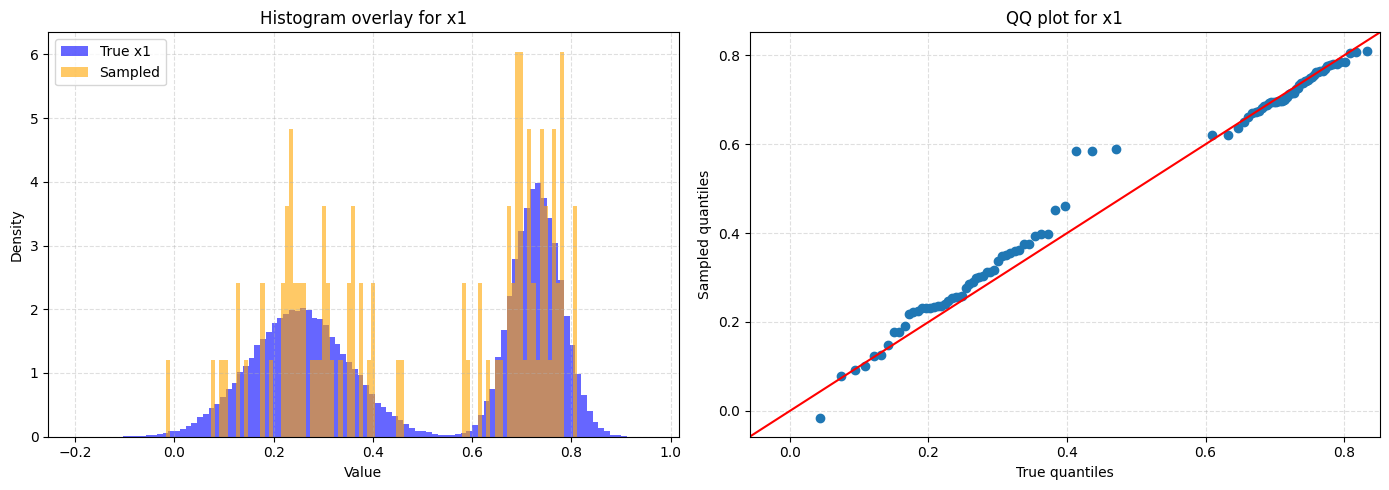

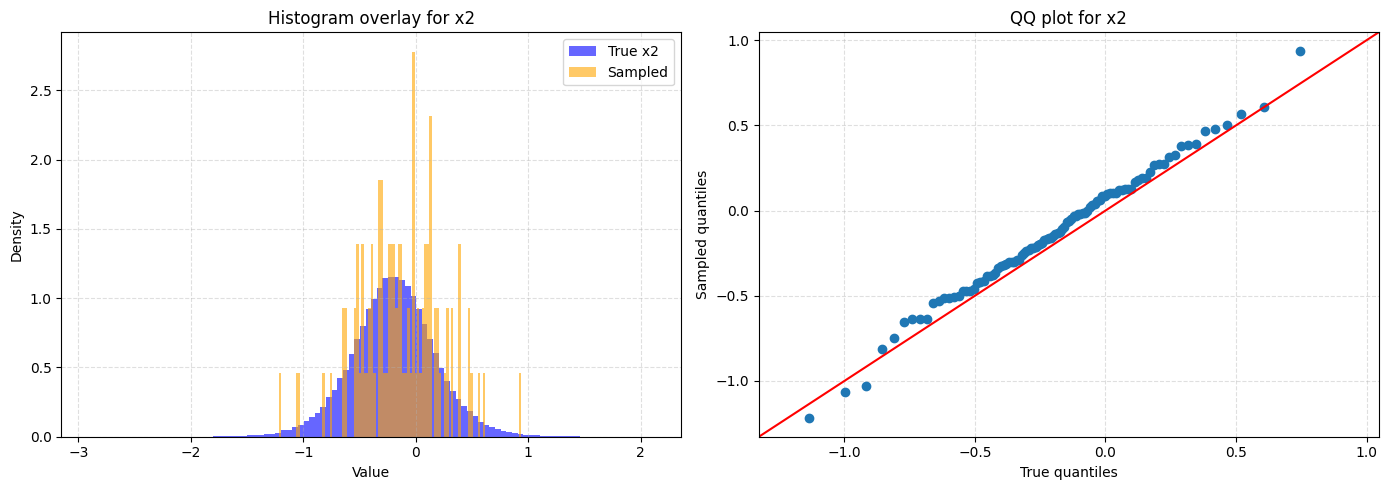

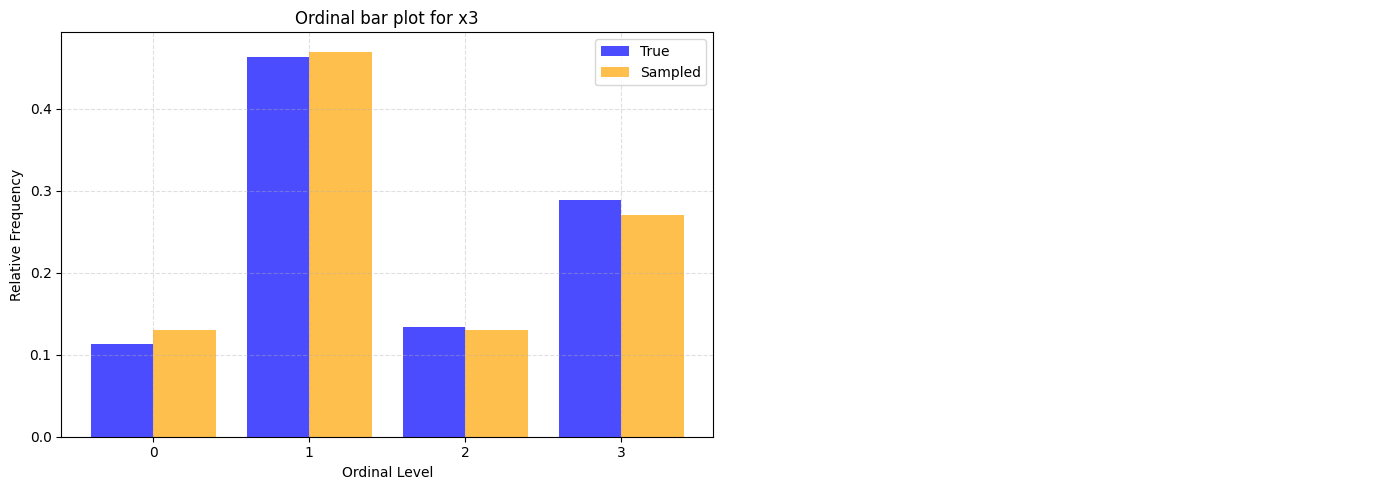

In [15]:
rsamples, latents = td_model.sample(number_of_samples=100)
td_model.plot_samples_vs_true(train_df,rsamples)


Deleted directory: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 43.46it/s]


----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[WARNING] target_col 'x3' not in DataFrame columns — is this intended to be used as a Sampler?


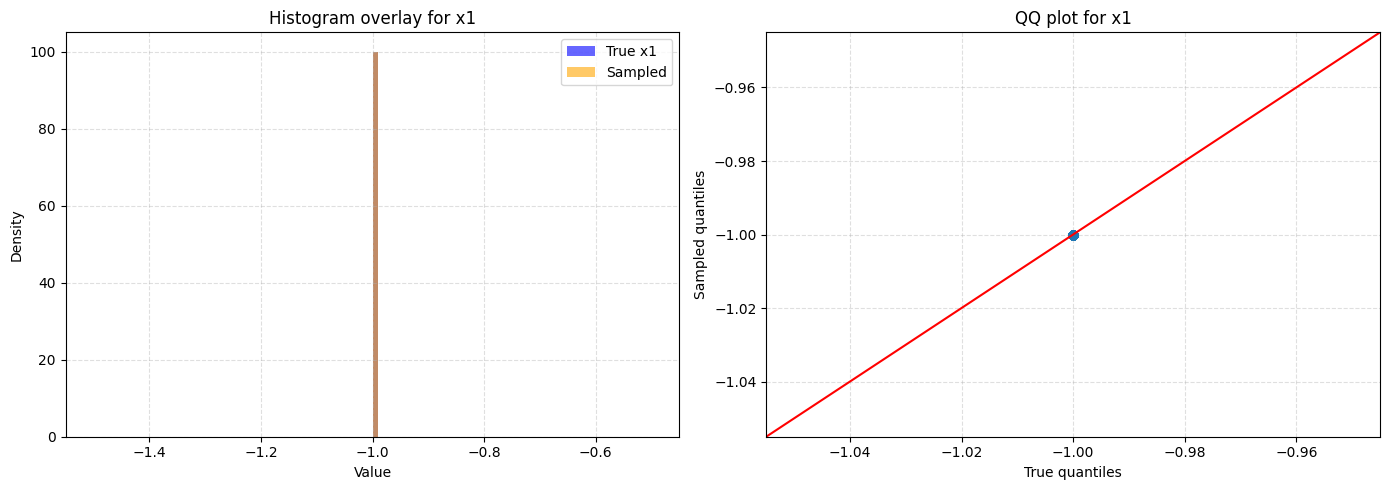

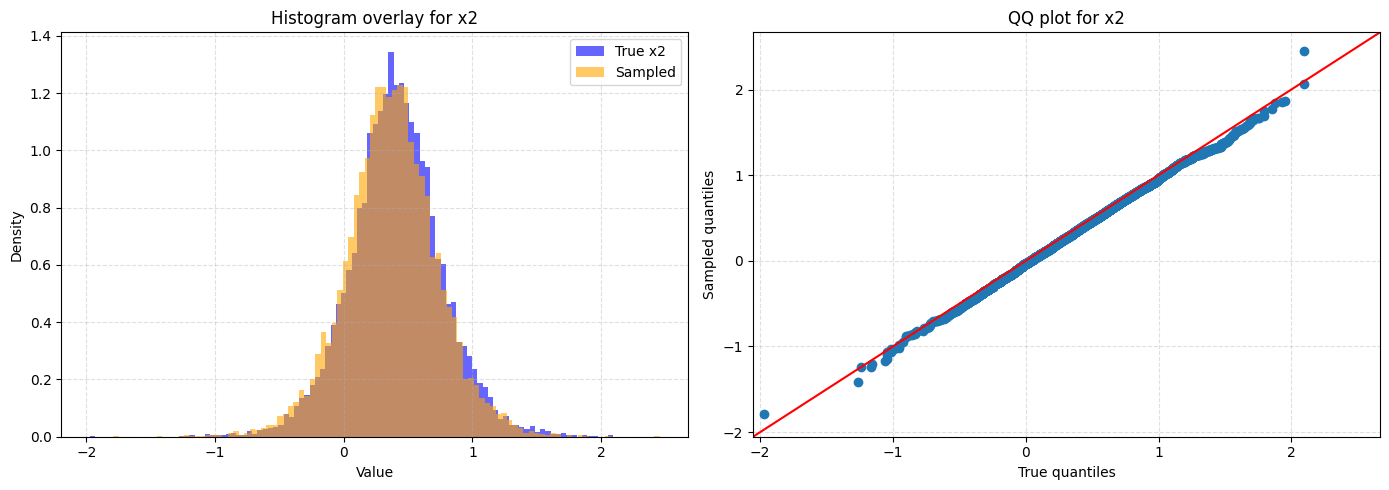

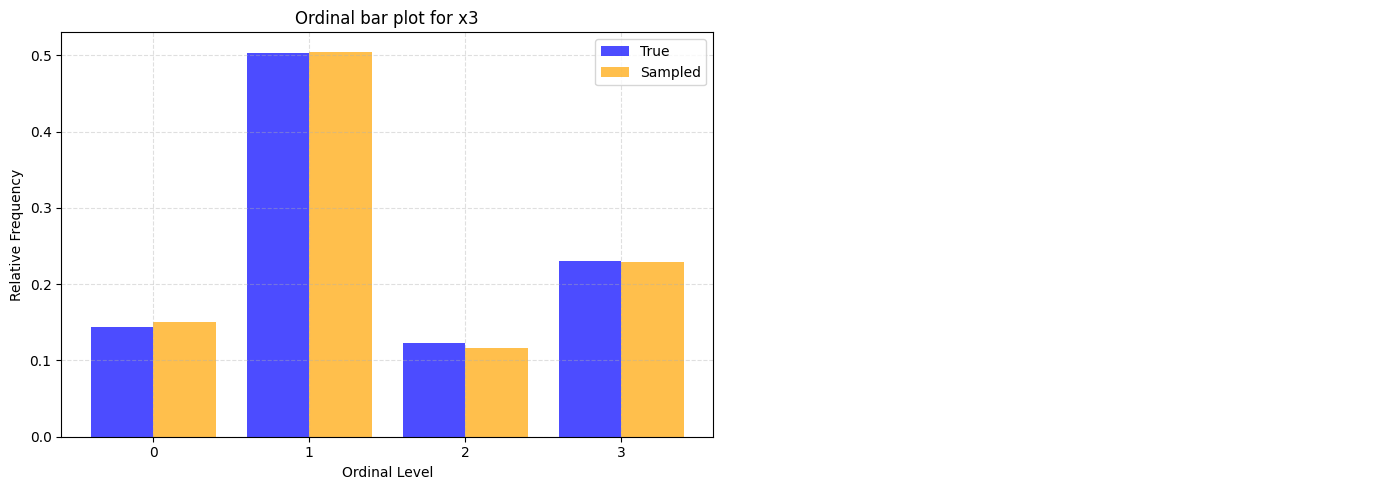

In [16]:
samples, latents = td_model.sample(do_interventions={'x1':-1.0})
inter_df=dgp(n_obs=10_000, doX=[-1.0,None , None])
td_model.plot_samples_vs_true(inter_df)

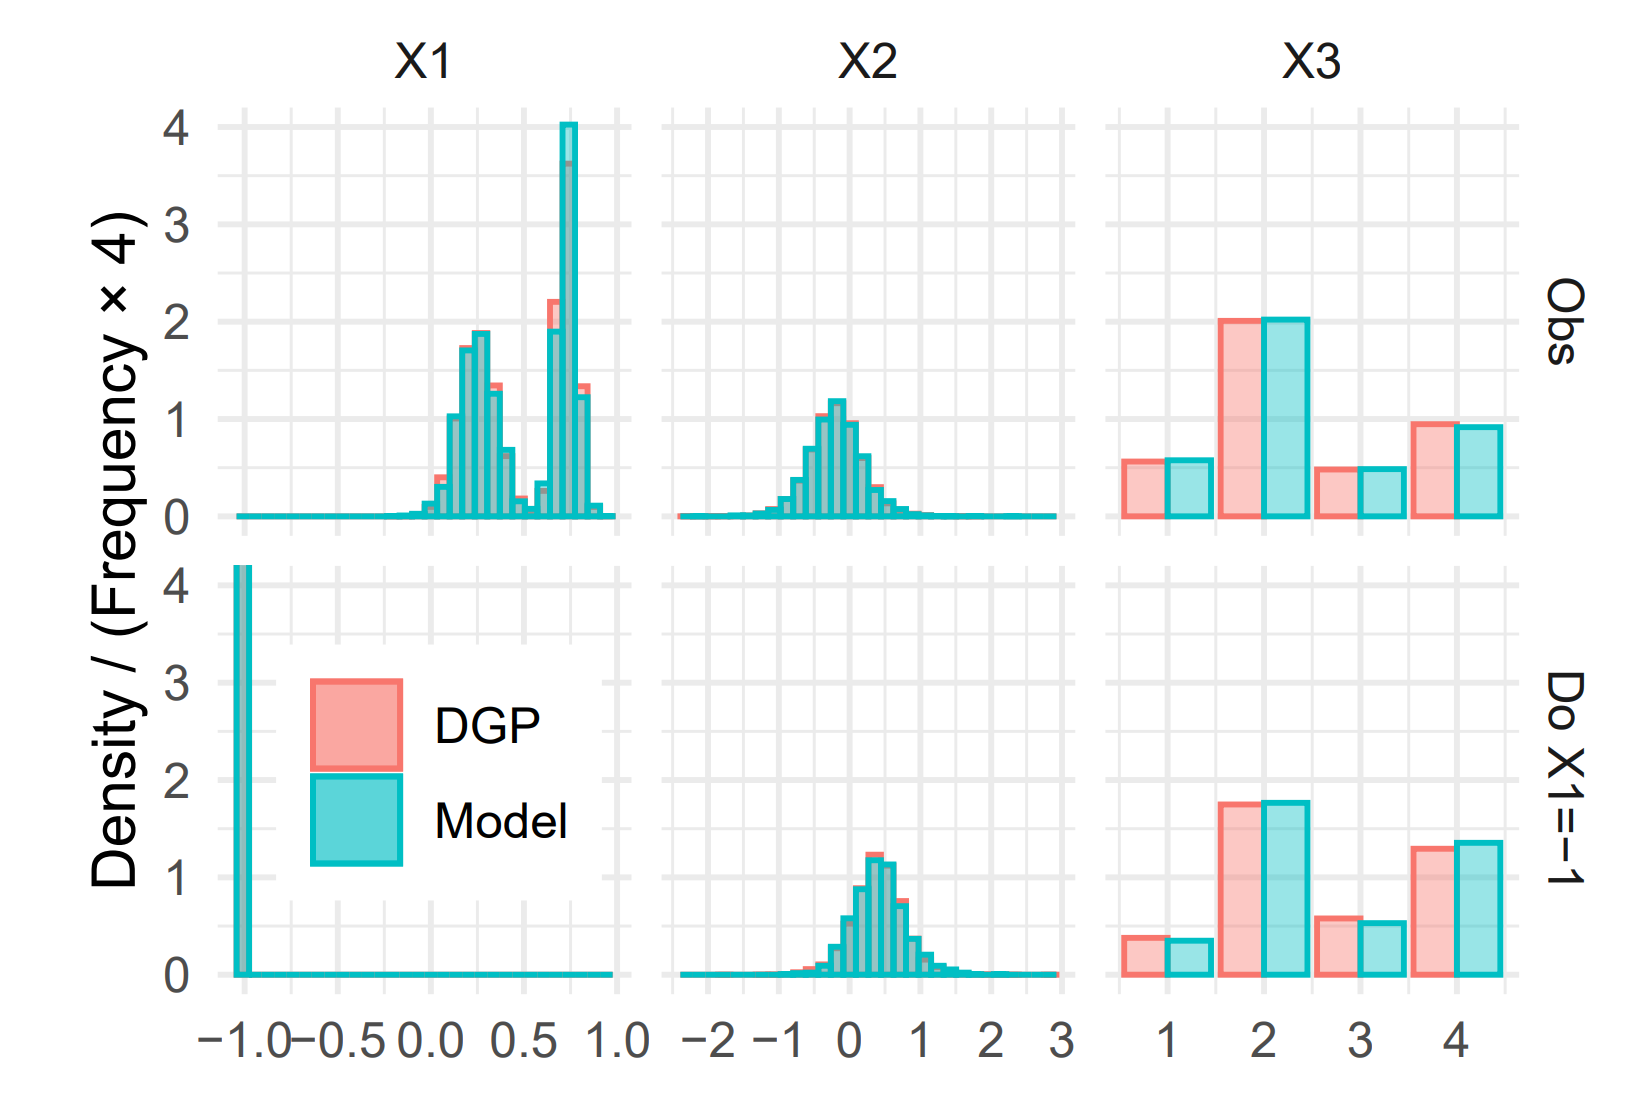

In [17]:

# verbose = False
# batch_size = 4112

# x = torch.linspace(-1, 1, steps=1000).unsqueeze(1).to(device)  # (100, 1)


# def f(x):
#     return 0.75*np.arctan(5*(x+0.12))  
# for node in node_list:
#     print(f'\n----*----------*-------------*--------check CS of {node} ------------*-----------------*-------------------*--')

#     if node_list[node]['node_type'] == 'source':
#         print("Node type : source, not supported yet.")
#         continue

#     # Load model
#     NODE_DIR = os.path.join(EXPERIMENT_DIR, node)
#     model_path = os.path.join(NODE_DIR, "best_model.pt")

#     tram_model= get_fully_specified_tram_model(node, configuration_dict, debug=True, set_initial_weights=False)
#     tram_model.load_state_dict(torch.load(model_path, map_location=device))
#     tram_model.to(device)   # <--- Move model to device
#     tram_model.eval()
    
#     for i, module in enumerate(tram_model.nn_shift):
#         module_name = module.__class__.__name__
#         if module_name == 'LinearShift':
#             print(f"Module {i} ({module_name}) weights:")
#             print(module.fc.weight.data)
#         else:
#             print(f"Module {i} ({module_name}) predictions:")
#             with torch.no_grad():
#                 y = module(x)
# plt.scatter(x.cpu().numpy(),y.cpu().numpy())
# plt.scatter(x.cpu().numpy(),-f(x.cpu().numpy()),cmap="red")
# plt.show()

In [18]:
    # def linear_shifts_from_model(self,state='best'):
    #     nodes_list = list(self.models.keys())
        
    #     linear_shift_dict={}
    #     for node in nodes_list:
    #         EXPERIMENT_DIR = self.cfg.conf_dict["PATHS"]["EXPERIMENT_DIR"]
    #         NODE_DIR = os.path.join(EXPERIMENT_DIR, f"{node}")
    #         BEST_MODEL_PATH, LAST_MODEL_PATH, _, _ = model_train_val_paths(NODE_DIR)
            
    #         if state=='best':
    #             LOAD_PATH=BEST_MODEL_PATH
    #         elif state=='last':
    #             LOAD_PATH=LAST_MODEL_PATH
                
    #         if not  os.path.exists(LOAD_PATH):
    #             LOAD_PATH = os.path.join(NODE_DIR, 'initial_model.pt')
    #             print(f"[WARNING] Model file not found for node {node} at {LOAD_PATH}. Using initial model instead.")
            
            
    #         state_dict = torch.load(LOAD_PATH, map_location=self.device)
    #         tram_model=self.models[node]
    #         tram_model.load_state_dict(state_dict)


    #         if  hasattr(tram_model, "nn_shift") and tram_model.nn_shift is not None:
    #             epoch_weights = {}
    #             for i, shift_layer in enumerate(tram_model.nn_shift):
    #                 module_name = shift_layer.__class__.__name__
    #                 if hasattr(shift_layer, "fc") and hasattr(shift_layer.fc, "weight") and module_name == 'LinearShift': :
                        
    #                     epoch_weights[f"shift_{i}"] = shift_layer.fc.weight.detach().cpu().tolist()
    #                 else:
    #                     if self.debug:
    #                         print(f"[DEBUG] shift_{i}: 'fc' or 'weight' or LinearShift not found.")
                            
    #             linear_shift_dict[node]=epoch_weights
    #     return linear_shift_dict

In [19]:
td_model.linear_shifts_from_model()

AttributeError: 'TramDagModel' object has no attribute 'linear_shifts_from_model'

In [ ]:
from tramdag.utils.tram_model_helpers import ordered_parents
_, terms_dict, model_names_dict =ordered_parents("x2", td_model.nodes_dict)
i=0
list(terms_dict.keys())[i]

In [ ]:
td_model.summary()